The file football.gml contains the network of American football games
between Division IA colleges during regular season Fall 2000, as compiled
by M. Girvan and M. Newman.  The nodes have values that indicate to which
conferences they belong.  The values are as follows:

  0 = Atlantic Coast
  1 = Big East
  2 = Big Ten
  3 = Big Twelve
  4 = Conference USA
  5 = Independents
  6 = Mid-American
  7 = Mountain West
  8 = Pacific Ten
  9 = Southeastern
 10 = Sun Belt
 11 = Western Athletic

If you make use of these data, please cite M. Girvan and M. E. J. Newman,
Community structure in social and biological networks,
Proc. Natl. Acad. Sci. USA 99, 7821-7826 (2002).

Correction: Two edges were erroneously duplicated in this data set, and
have been removed (21 SEP 2014)

BrighamYoung         12
FloridaState         12
Iowa                 12
KansasState          12
NewMexico            11
TexasTech            12
PennState            12
SouthernCalifornia   12
ArizonaState         11
SanDie

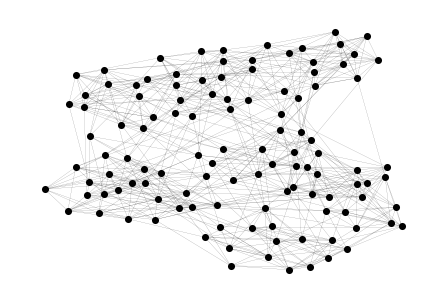

In [20]:

# Import and create graph of the football network provided by NetworkX
import urllib.request
import io
import zipfile
import numpy as np
import random

import matplotlib.pyplot as plt
import networkx as nx

url = "http://www-personal.umich.edu/~mejn/netdata/football.zip"

sock = urllib.request.urlopen(url)  # open URL
s = io.BytesIO(sock.read())  # read into BytesIO "file"
sock.close()

zf = zipfile.ZipFile(s)  # zipfile object
txt = zf.read("football.txt").decode()  # read info file
gml = zf.read("football.gml").decode()  # read gml data
# throw away bogus first line with # from mejn files
gml = gml.split("\n")[1:]
G = nx.parse_gml(gml)  # parse gml data

print(txt)
# print degree for each team - number of games
for n, d in G.degree():
    print(f"{n:20} {d:2}")

options = {"node_color": "black", "node_size": 50, "linewidths": 0, "width": 0.1}

pos = nx.spring_layout(G, seed=1969)  # Seed for reproducible layout
nx.draw(G, pos, **options)
plt.show()

In [12]:
# Get the degree sequence of the network
degreeSequence = []
for n, d in G.degree():
    degreeSequence.append(d)

# Create configuration model from the degree sequence
configurationModel = nx.configuration_model(degreeSequence)

# Go from MultiGraph to Graph (Remove parallel edges)
configurationModel = nx.Graph(configurationModel)


In [13]:
# 1. Edges deleted are chosen randomly
numberOfSimulation = 10
numberOfStepsAlpha = 100
alphas = np.linspace(0, 1, numberOfStepsAlpha)
clusterCoefficientMatrix = np.zeros((numberOfSimulation, numberOfStepsAlpha))




# Loop over of simulations
for i in range(numberOfSimulation):
    
    # Loop over alphas
    for j in range(numberOfStepsAlpha):

        # Initialize network
        network = G.copy()
        # network = configurationModel.copy()
        
        # Fetch alpha
        alpha = alphas[j]

        # Find the amount of edges to delete
        numberOfEdges = network.number_of_edges()
        numberOfDeletedEdges = round(numberOfEdges * alpha)
        # print(f"Number of edges before: {numberOfEdges}")

        # Delete random nodes
        for k in range(numberOfDeletedEdges):
       
            # Select random edge to be deleted
            randomSample = random.sample(network.edges(), 1)

            # Delete random node
            network.remove_edges_from(randomSample)
        
        # print(f"Number of edges after deletion: {network.number_of_edges()}")


        # Calculate global clustering coefficient for the alpha      
        clusterCoefficientMatrix[i,j] = nx.transitivity(network)

In [14]:
# Take average over the simulations
clusterCoefficientList =[]
for i in range(numberOfStepsAlpha):
    clusterCoefficientList.append(np.mean(clusterCoefficientMatrix[:,i]))

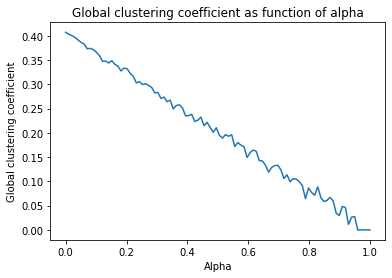

In [15]:
# Plotting
plt.figure(1)
plt.title("Global clustering coefficient as function of alpha")
plt.plot(alphas, clusterCoefficientList)
plt.ylabel("Global clustering coefficient")
plt.xlabel("Alpha")
plt.show()



## 2

In [22]:

numberOfNodes = G.number_of_nodes()
numberOfEdges = configurationModel.number_of_edges()

clusterCoefficientMatrix2 = np.zeros((numberOfSimulation, numberOfStepsAlpha))


for i in range(numberOfSimulation):
    for j, alpha in enumerate(alphas):

        network = configurationModel.copy()

        degrees = network.degree()
        edgesToRemove = round(alpha * numberOfEdges)

        for edge in range(edgesToRemove):
            node = sorted(degrees, key=lambda x: x[1], reverse=True)[0]
            edges = network.edges(node)
            
            # print(random.sample(list(edges), 1))
     
            network.remove_edges_from(random.sample(list(edges), 1))
            

        clusterCoefficientMatrix2[i,j] = nx.transitivity(network)



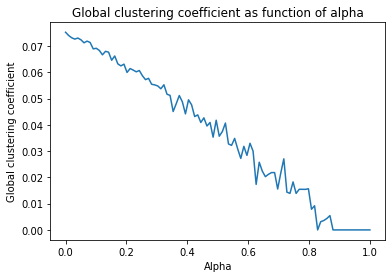

In [23]:
# Take average over the simulations
clusterCoefficientList2 =[]
for i in range(numberOfStepsAlpha):
    clusterCoefficientList2.append(np.mean(clusterCoefficientMatrix2[:,i]))

# Plotting
plt.figure(2)
plt.title("Global clustering coefficient as function of alpha")
plt.plot(alphas, clusterCoefficientList2)
plt.ylabel("Global clustering coefficient")
plt.xlabel("Alpha")
plt.show()

## 3

In [30]:


# Start with random node. Remove alpha * nNeighbors edges, choose the neighbor with the highest degree and 
# repeat the process of deleting edges and choosing next node

from networkx import all_neighbors

numberOfSimulation = 10

G = nx.parse_gml(gml)  # parse gml data
numberOfNodes = G.number_of_nodes()
clusterCoefficientMatrix3 = np.zeros((numberOfSimulation, numberOfStepsAlpha))


for i in range(numberOfSimulation):
    for j, alpha in enumerate(alphas):

        network = G.copy()
        numberOfEdges = network.number_of_edges()
        nrEdgesToRemove = round(alpha*numberOfEdges)
        currentNode = random.sample(network.nodes(), 1)[0]

        while True:
            edges = network.edges(currentNode)
            if (len(edges) == 0):
                currentNode = random.sample(network.nodes(), 1)[0]
                continue
            edgesToRemove = random.sample(list(edges), 1)
            network.remove_edges_from(edgesToRemove)
            nrEdgesToRemove -= 1
            maxDegree = 0
            neighbors = list(all_neighbors(network, currentNode))
            if len(neighbors) == 0:
                currentNode = random.sample(network.nodes(), 1)[0]
                continue
            nextNode = None
            for k, n in enumerate(neighbors):
                if network.degree(n) > maxDegree:
                    maxDegree = network.degree(n)
                    nextNode = n

            currentNode = nextNode

            if edgesToRemove == 0:
                break
            print(f"Edges left to remove: {nrEdgesToRemove}")


        clusterCoefficientMatrix3[i,j] = nx.transitivity(network)



# Take average over the simulations
clusterCoefficientList3 =[]
for i in range(numberOfStepsAlpha):
    clusterCoefficientList3.append(np.mean(clusterCoefficientMatrix3[:,i]))

# Plotting
plt.figure(2)
plt.title("Global clustering coefficient as function of alpha")
plt.plot(alphas, clusterCoefficientList3)
plt.ylabel("Global clustering coefficient")
plt.xlabel("Alpha")
plt.show()
    
        
        


Edges left to remove: -1
Edges left to remove: -2
Edges left to remove: -3
Edges left to remove: -4
Edges left to remove: -5
Edges left to remove: -6
Edges left to remove: -7
Edges left to remove: -8
Edges left to remove: -9
Edges left to remove: -10
Edges left to remove: -11
Edges left to remove: -12
Edges left to remove: -13
Edges left to remove: -14
Edges left to remove: -15
Edges left to remove: -16
Edges left to remove: -17
Edges left to remove: -18
Edges left to remove: -19
Edges left to remove: -20
Edges left to remove: -21
Edges left to remove: -22
Edges left to remove: -23
Edges left to remove: -24
Edges left to remove: -25
Edges left to remove: -26
Edges left to remove: -27
Edges left to remove: -28
Edges left to remove: -29
Edges left to remove: -30
Edges left to remove: -31
Edges left to remove: -32
Edges left to remove: -33
Edges left to remove: -34
Edges left to remove: -35
Edges left to remove: -36
Edges left to remove: -37
Edges left to remove: -38
Edges left to remove:

KeyboardInterrupt: 